# Lab 2

# Test

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gmm import GMM
import pandas as pd

## Exercice 1

In [2]:
N = 100 # Number of states

def generate_pdf(N):
    pi = np.random.rand(N)
    # pi = np.ones(N)
    pi /= pi.sum()
    return pi
cdf_pi = generate_pdf(N)

def generate_samples(N, pdf):
    cdf = np.cumsum(pdf)
    U = np.random.rand(N)
    for idx_u in range(len(U)):
        x = 0
        while x < len(cdf) and U[idx_u] > cdf[x]:
            x += 1
        U[idx_u] = x
    return U

def plot_cdf(cdf, color):
    for k in range(len(cdf)):
        previous_value, value = cdf[k-1] if k>0 else 0, cdf[k] 
        plt.plot([k, k], [previous_value, value], color=color)
        plt.scatter(k, value, color=color)
        if k+1 < len(cdf):
            plt.plot([k, k+1], [value, value], color=color)

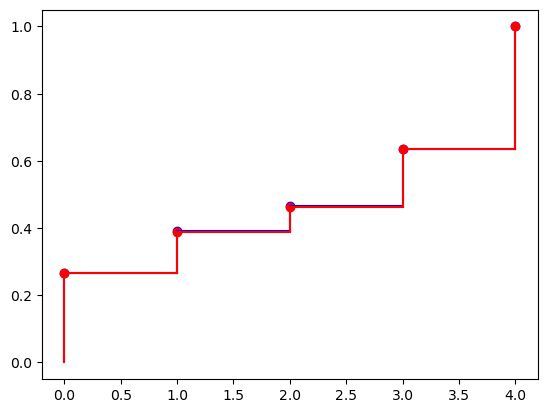

In [3]:
N = 5
pdf_pi = generate_pdf(N)
X = generate_samples(100_000, pdf_pi)

# Plot the experimental distribution
cdf_exp = {int(key): (X <= key).sum()/len(X) for key in np.linspace(0, N-1, N)}
plot_cdf(cdf_exp, "blue")

# Plot the theoretical distribution
plot_cdf(np.cumsum(pdf_pi), "red")

## Exercie 2

### Generate the data

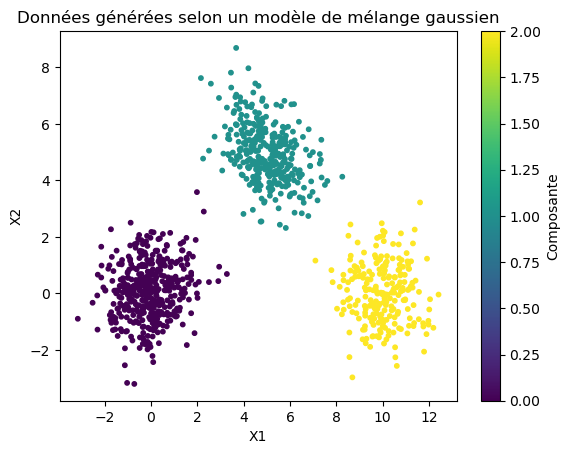

In [4]:
# Paramètres du modèle de mélange gaussien
M = 3  # Nombre de composantes du mélange
N = 1000  # Nombre d'échantillons

# Poids pour chaque composante (doit sommer à 1)
alphas = [0.45, 0.35, 0.25]

# Moyennes et matrices de covariance de chaque composante
means = np.array([np.array([0, 0]), np.array([5, 5]), np.array([10, 0])])
covariances = np.array([np.array([[1, 0.2], [0.2, 1]]), 
               np.array([[1, -0.3], [-0.3, 1]]), 
               np.array([[1, 0], [0, 1]])])

# Génération des données
X = np.zeros((N, 2))  # Tableau pour stocker les données
Z = generate_samples(N, pdf=alphas)  # Sélectionne les classes de chaque échantillon

for i in range(M):
    # Nombre d'échantillons pour la i-ème composante
    n_i = np.sum(Z == i)
    # Génération des échantillons gaussiens pour cette composante
    X[Z == i] = np.random.multivariate_normal(means[i], covariances[i], size=n_i)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=Z, cmap='viridis', s=10)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Données générées selon un modèle de mélange gaussien")
plt.colorbar(label="Composante")
plt.show()


# Implement the GMM

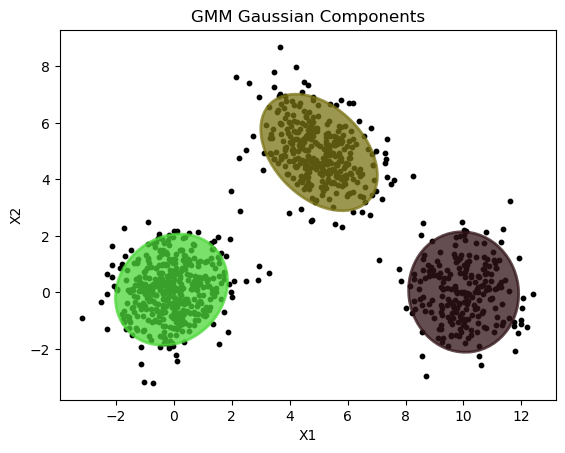

In [5]:
gmm = GMM(M=3, X=X, dim=2)
gmm.fit(max_iter=50, verbose=False)
gmm.plot_gmm_ellipses()

[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]


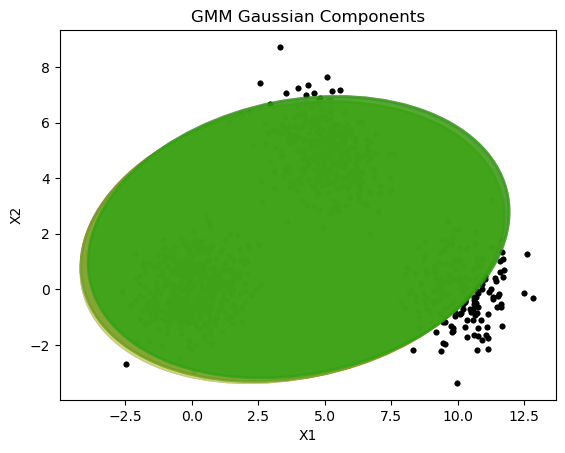

[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]
[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]
[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]
[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]
[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]
[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]
[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]
[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]
[[0.58933853 0.31427192 0.48231608]
 [0.78119703 0.43863082 0.06924453]
 [0.77699104 0.4756931  0.69949296]]
[[0.58933853 0.3142

KeyboardInterrupt: 

In [6]:
gmm.animate_gmm_fit(X, save=True)

## Implementation on real case study

/var/folders/pb/_7l8b_td5_jfqdxkmrdd2gf40000gn/T/ipykernel_17093/2741787807.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Demo_data.csv")


<Axes: xlabel='CBR', ylabel='CDR'>

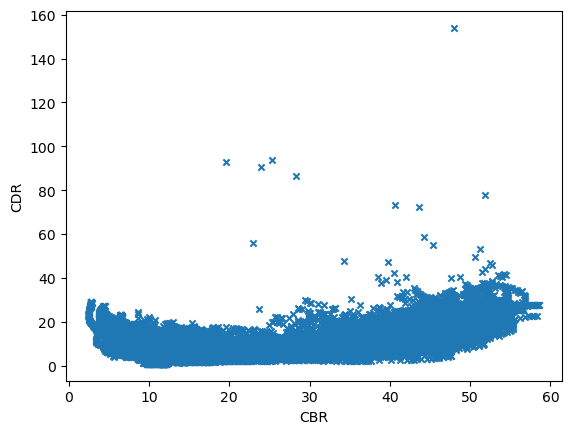

In [6]:
df = pd.read_csv("Demo_data.csv")
df = df[["CBR", "CDR"]].dropna(how='any', axis=0)
df.plot(kind="scatter", x="CBR", y="CDR", marker="x")

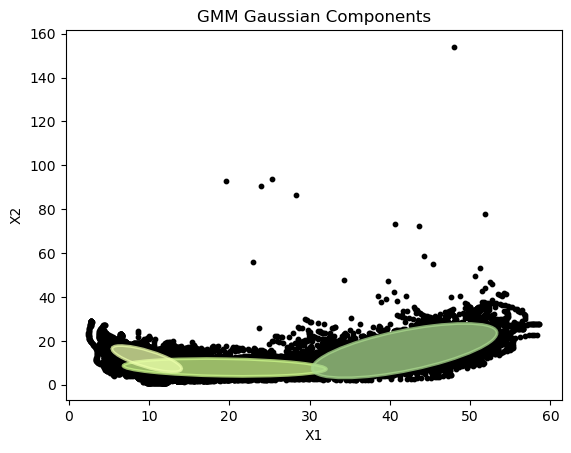

In [10]:
gmm = GMM(M=3, X=df.values, dim=2)
gmm.fit(max_iter=1_000, verbose=False)
gmm.plot_gmm_ellipses()

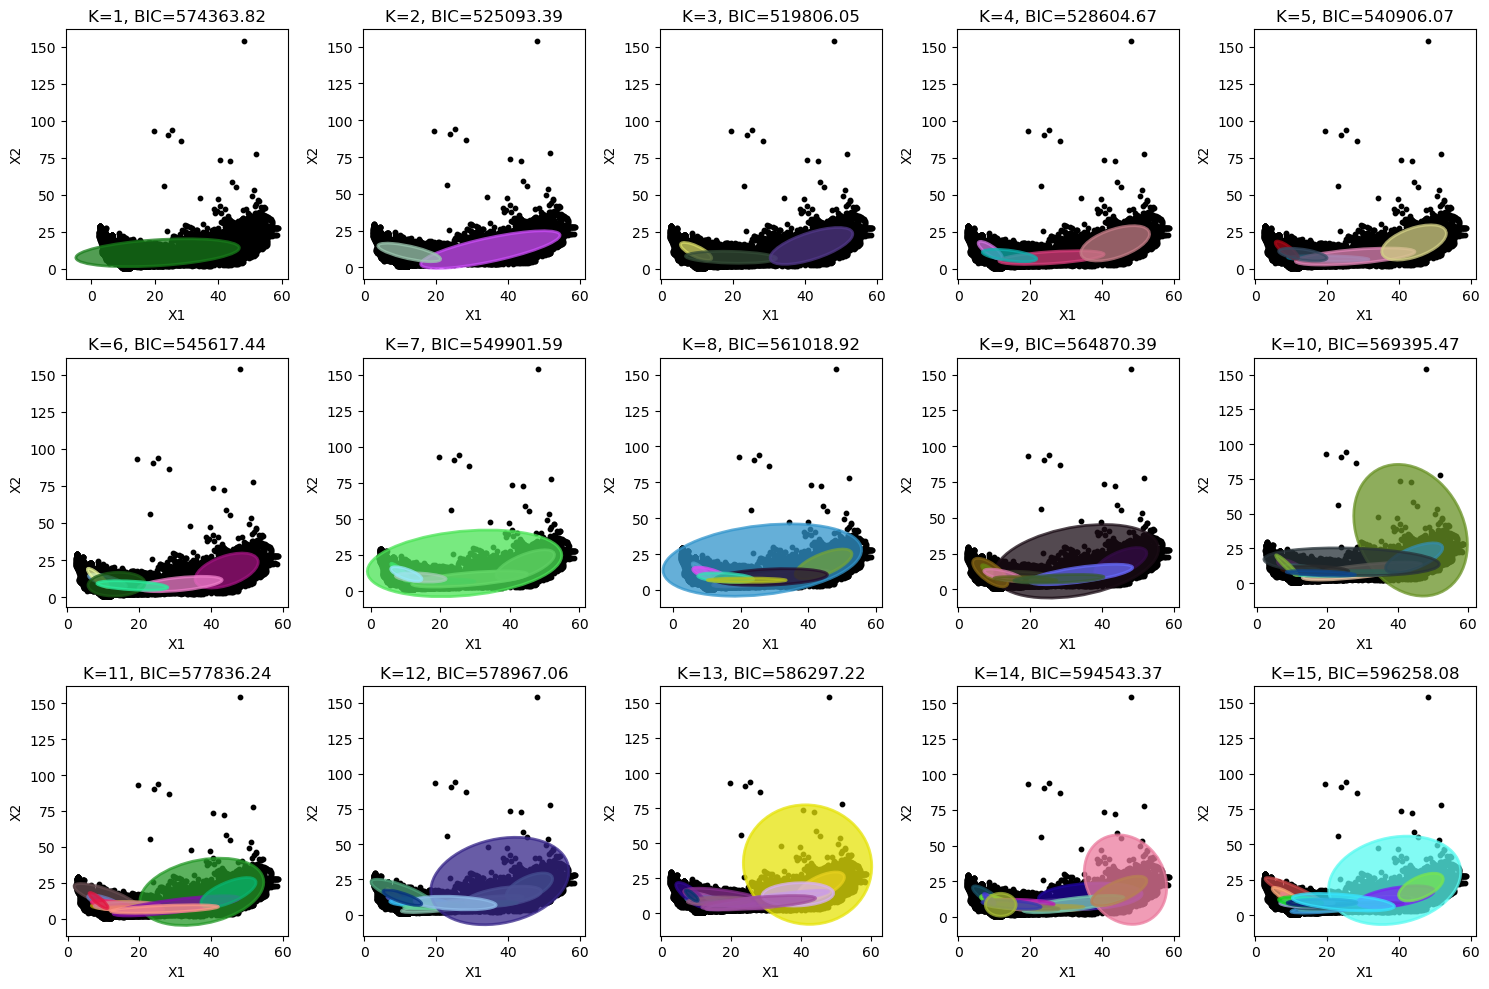

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for n_clusters in range(1, 16):
    plt.subplot(3, 5, n_clusters)
    gmm = GMM(M=n_clusters, X=df.values)
    gmm.fit(max_iter=200, verbose=False)
    gmm.plot_gmm_ellipses(ax=axes[(n_clusters-1)//5, (n_clusters-1)%5])
    plt.title(f"K={n_clusters}, BIC={round(gmm.bic(), 2)}")

plt.tight_layout()
plt.show()